# Programming assignment 1: Aligning Prokudin-Gorskii images
(adapted from Alexei Efros@UC Berkeley and Subhransu Maji@UMass Amherst)

<font size="4">Sergei Mikhailovich Prokudin-Gorskii (1863-1944) was a man well ahead of his time. Convinced, as early as 1907, that color photography was the wave of the future, he won Tzar’s special permission to travel across the vast Russian Empire and take color photographs of everything he saw including the only color portrait
of Leo Tolstoy. And he really photographed everything: people, buildings, landscapes, railroads, bridges...
thousands of color pictures! His idea was simple: record three exposures of every scene onto a glass plate
using a red, a green, and a blue filter. Never mind that there was no way to print color photographs until
much later – he envisioned special projectors to be installed in ”multimedia” classrooms all across Russia
where the children would be able to learn about their vast country. Alas, his plans never materialized: he
left Russia in 1918, right after the revolution, never to return again. Luckily, his RGB glass plate negatives,
capturing the last years of the Russian Empire, survived and were purchased in 1948 by the Library of
Congress. The LoC has recently digitized the negatives and made them available on-line.</font>

<img src='meta_data/example-Prokudin-Gorskii.png' height='1200'/>
<font size="3">Figure 1: Example image from the Prokudin-Gorskii collection. On the left are the three images captured
individually. On the right is a reconstructed color photograph. Note the colors are in B, G, R order from the
top to bottom (and not R, G, B)!</font>

<font size="4">Your goal is to take photographs of each plate and generate a color image by aligning them (as shown in the right of Figure 1). The easiest way to align the plates is to exhaustively search over a window of possible displacements
(say [-15,15] pixels), score each one using some image matching metric, and take the displacement with
the best score.</font> 

## Module import and image reading

In [1]:
# Jupyter notebook autoload module setting
# see https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
plt.close('all')

import os
import glob
import time
import numpy as np
import cv2
import math

(1024, 394)
0.0 255.0


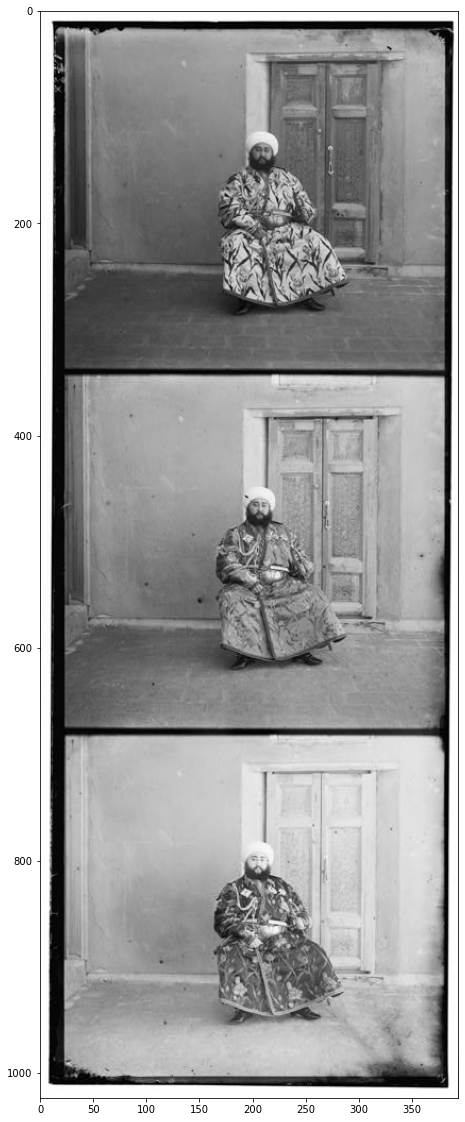

In [2]:
# load a single gray-scale image
raw_im = cv2.imread('data/00153v.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float32)
print(raw_im.shape)
print(raw_im.min(), raw_im.max())
# the output of these two print calls should be
# (1024, 394)
# 0 255

# let's do a simple visualization
plt.figure(figsize = (20,20))
plt.imshow(raw_im, cmap='gray', vmin=0, vmax=255)
# you should be able to see a grayscale image showing a person sitting there

## Programming assignment starts here (100 points in total)

<font size="4" color="red">**task 1: split the raw image into three parts (5 points)**</font><br><br>
<font size="4"> We can see there are three photos shown above. These photos represent images captured with a blue, green, and red filter. The first task you need to do is to split the raw image vertically into three parts. 
Note the photos are in B, G, R order from the top to bottom (and not R, G, B)!</font>

In [3]:
def split_raw_image(raw_im):
    # implement the function to split the raw_im vertically into three images
    # corresponding to the B, G, R channel, respectively
    # three channels should have the same spatial dimensions
    
    # replace the dummpy implmentation with your own
    height, width = raw_im.shape
    im_r, im_g, im_b = raw_im[(2 * height // 3) : (height - height % 3), :], raw_im[(height // 3) : (2 * height // 3), :], raw_im[0 : (height // 3), :]

    return im_r, im_g, im_b

### sanity check: let's visualize the split results

(341, 394) (341, 394) (341, 394)


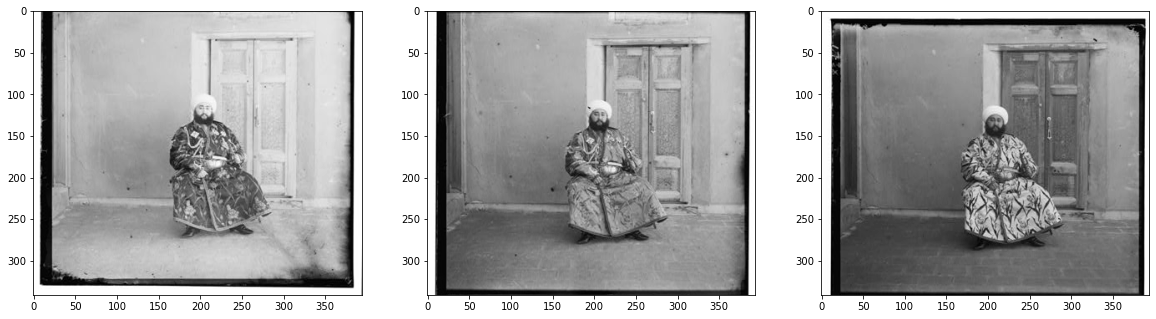

In [4]:
# now let's do a visualization to see if they look
im_r, im_g, im_b = split_raw_image(raw_im)
print(im_r.shape, im_g.shape, im_b.shape)

plt.figure(figsize = (20,20))

# channel R
ax1 = plt.subplot(1, 3, 1)
ax1.imshow(im_r, cmap='gray', vmin=0, vmax=255)

# channel G
ax2 = plt.subplot(1, 3, 2)
ax2.imshow(im_g, cmap='gray', vmin=0, vmax=255)

# channel B
ax3 = plt.subplot(1, 3, 3)
ax3.imshow(im_b, cmap='gray', vmin=0, vmax=255)

<font size="4" color="red">**task 2: implement a function that tells us how close two images are (10 points)**</font><br><br>
<font size="4">There is a number of possible metrics that one could use to score how well the images match. We are going to use the normalized cross-correlation (NCC), which is simply a dot product between two normalized vectors. Specifically, given two channel photots, we treat each of them as a vector, normalize each of them with L2 norm, and compute the dot product between them.</font>

In [5]:
def normalized_cross_correlation(ref_im, input_im):
    # calculate and return the ncc between the ref_im and input_im
    # sanity check
    assert len(ref_im.shape) == 2
    assert len(input_im.shape) == 2
    
    # replace the dummpy implmentation with your own
    ref_im_flat = ref_im.flatten()
    input_im_flat = input_im.flatten()
    ncc = np.dot(ref_im_flat / np.linalg.norm(ref_im_flat), input_im_flat / np.linalg.norm(input_im_flat))
    
    return ncc

<font size="4" color="red">**task 3: find the best displacements between two channels to align one to the other (30 points)**</font><br><br>
<font size="4">We need to consider displacements in both the horizontal and vertical directions.</font> 

<font size="4">**Hint 1**: Use `np.roll()` to offset the channels while keeping the same dimensions among them. **Note that the roll is circular** that means if you roll the image to the left, the left edge goes to the right. This also happens to the vertical roll. </font>

In [6]:
def get_best_displacement(im1, im2, x_disp=(-15, 15), y_disp=(-15, 15)):
    # im1: one channel image
    # im2: the other channel image
    # x_disp: minimum and maximum of the horizontal displacement
    # y_disp: minimum and maximum of the vertical displacement
    
    # replace the dummy implmentation with your own
    best_x_disp, best_y_disp = 0, 0
    max_ncc = 0
    
    for x in range(x_disp[0], x_disp[1] + 1):
        for y in range(y_disp[0], y_disp[1] + 1):
            rolled_im2 = np.roll(im2, (x, y), axis=(1, 0))
            ncc = abs(normalized_cross_correlation(im1, rolled_im2))
            if ncc > max_ncc:
                max_ncc = ncc
                best_x_disp = x
                best_y_disp = y
    
    return best_x_disp, best_y_disp

<font size="4" color="red">**task 4: align and combine three channels together to get a colorful image (20 points)**</font><br><br>
<font size="4">Finally, we fix the R (red) channel and align the rest two to it and combine them together to get a colorful image. Your implementation shouldn't be too slow. Our reference implementation takes about 0.75s on our computer with an Intel® Xeon(R) E-2276M CPU @ 2.80GHz CPU.</font>

In [7]:
def get_color_image(im_r, im_g, im_b, disp_search_func=get_best_displacement):
    # im_r: R channel
    # im_g: G channel
    # im_b: B channel
    # output the colorful image and the best displacement found
    
    # note that disp_search_func is a callable function
    # you can directly use it as
    # best_x_disp, best_y_disp = disp_search_func(im_g, im_b)
    
    # replace this dummy implementation with yours
    best_g_disp = disp_search_func(im_r, im_g)
    best_b_disp = disp_search_func(im_r, im_b)
    im_color = np.zeros((im_r.shape[0], im_r.shape[1], 3))
    im_color[:, :, 0] = im_r
    im_color[:, :, 1] = np.roll(im_g, best_g_disp, axis=(1, 0))
    im_color[:, :, 2] = np.roll(im_b, best_b_disp, axis=(1, 0))
    
    return im_color, best_g_disp, best_b_disp

### let's visualize the final result

G channel, x-disp: -2, y-disp: -13
B channel, x-disp: -3, y-disp: -11
Elapsed time: 0.399s


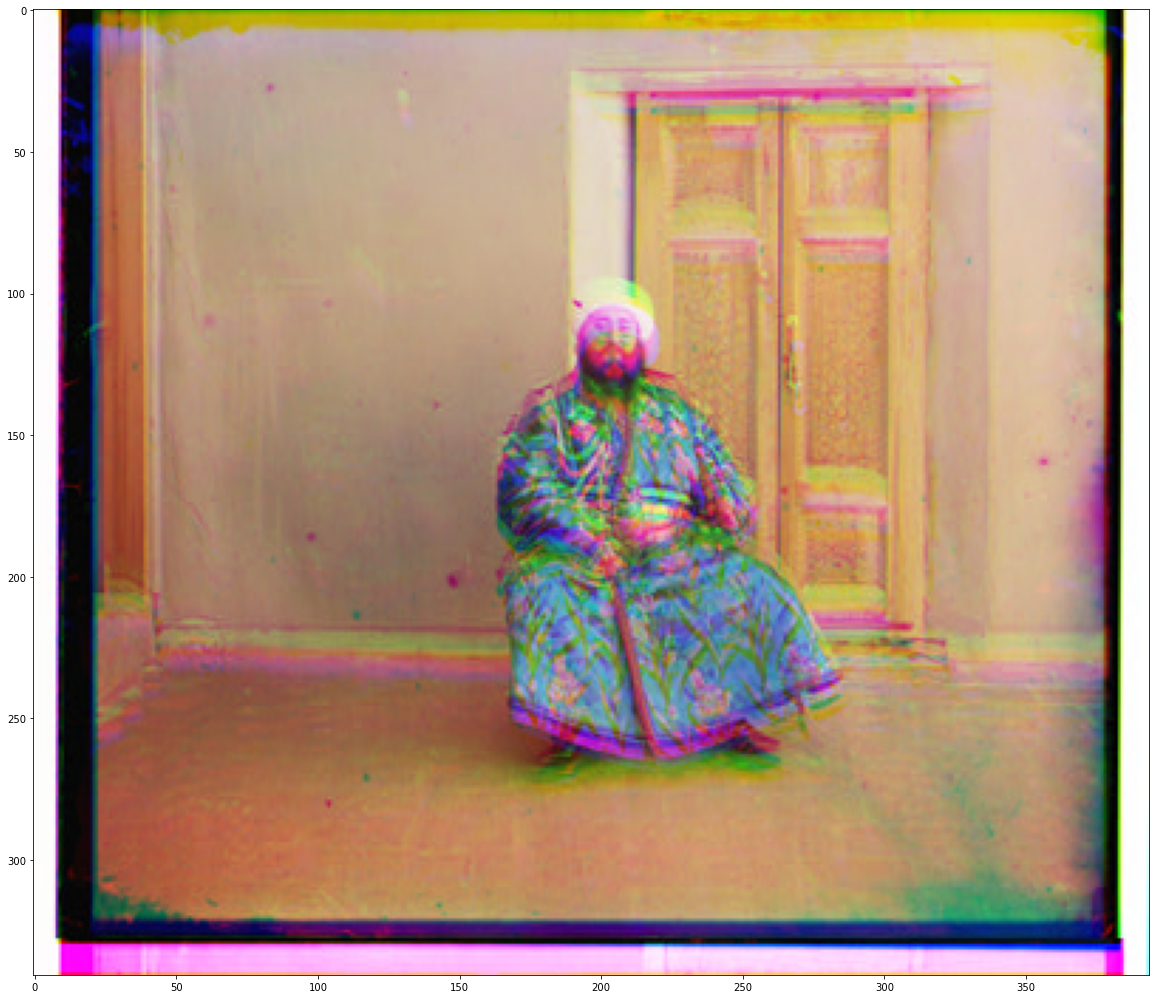

In [8]:
tic = time.time()
im_color, best_g_disp, best_b_disp = get_color_image(im_r, im_g, im_b)
toc = time.time()
print('G channel, x-disp: {}, y-disp: {}'.format(best_g_disp[0], best_g_disp[1]))
print('B channel, x-disp: {}, y-disp: {}'.format(best_b_disp[0], best_b_disp[1]))
print('Elapsed time: {:.3f}s'.format(toc - tic))

plt.figure(figsize = (20,20))
plt.imshow(im_color.astype(np.uint8))

### if you are satisfied with your implmentation, run them on a batch of images, and save the results
<font size="4">Note if the `output` directory exists, results there will be overwritten.</font>

In [9]:
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)
im_paths = sorted(glob.glob('data/*.jpg'))
for im_path_i in im_paths:
    im_name_i = os.path.basename(im_path_i)
    raw_im_i = cv2.imread(im_path_i, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    tic = time.time()
    im_r, im_g, im_b = split_raw_image(raw_im_i)
    im_color, best_g_disp, best_b_disp = get_color_image(im_r, im_g, im_b)
    toc = time.time()
    cv2.imwrite(os.path.join(output_dir, im_name_i), im_color.astype(np.uint8)[:, :, ::-1])
    print(im_name_i)
    print('G channel, x-disp: {}, y-disp: {}'.format(best_g_disp[0], best_g_disp[1]))
    print('B channel, x-disp: {}, y-disp: {}'.format(best_b_disp[0], best_b_disp[1]))
    print('Elapsed time: {:.3f}s'.format(toc - tic))
    print('===\n')
    

00125v.jpg
G channel, x-disp: 1, y-disp: -4
B channel, x-disp: 2, y-disp: -10
Elapsed time: 0.482s
===

00149v.jpg
G channel, x-disp: 0, y-disp: -5
B channel, x-disp: -1, y-disp: -9
Elapsed time: 0.390s
===

00153v.jpg
G channel, x-disp: -2, y-disp: -13
B channel, x-disp: -3, y-disp: -11
Elapsed time: 0.464s
===

00351v.jpg
G channel, x-disp: 0, y-disp: -9
B channel, x-disp: 1, y-disp: -13
Elapsed time: 0.461s
===

00398v.jpg
G channel, x-disp: 1, y-disp: 0
B channel, x-disp: 2, y-disp: -8
Elapsed time: 0.394s
===

01112v.jpg
G channel, x-disp: -1, y-disp: -8
B channel, x-disp: -3, y-disp: -8
Elapsed time: 0.380s
===



<font size="4" color="red">**task 5: coarse-to-fine alignment using image pyramid (35 points)**</font><br><br>
<font size="4">Searching over large displacements can be slow especially for high-resolution images. An efficient solution is to resize images to form two image pyramids, where each pyramid level downsamples the image in the previous level by factor 2. The idea is that we search for the best dispalcements on the smallest resolution and gradually refine the dispalcements in the larger resolutions.</font>

<font size="4">**Hint 1**: Suppose in a coarse image pyramid level k, the best displacements we find is (dx, dy). What should such displacments be in the finer image pyramid level k-1? Recall the spatial resolution of k-level is half of the resolution of (k-1)-level.</font>

<font size="4">**Hint 2**: You can use the `cv2.resize()` function to downsample an image.</font>

In [10]:
def get_best_displacement_pyramid(im1, im2, x_disp=(-15, 15), y_disp=(-15, 15), num_pyramid=4):
    # compared to the get_best_displacement function, here we have an extra input
    # num_pyramid denotes the number of pyramid level to use
    
    # replace the dummy implmentation with your own
    best_x_disp, best_y_disp = 0, 0
    
    im1_pyr, im2_pyr = [im1], [im2]
    percent = 50
    height, width = im1.shape
    
    for i in range(num_pyramid):
        im1_pyr.append(cv2.resize(im1, (int(height * percent / 100), int(width * percent / 100)), interpolation=cv2.INTER_NEAREST))
        im2_pyr.append(cv2.resize(im2, (int(height * percent / 100), int(width * percent / 100)), interpolation=cv2.INTER_NEAREST))
        percent /= 2
    
    x_disp = (-math.ceil(abs(x_disp[0])**(1 / num_pyramid)), math.ceil(abs(x_disp[1])**(1 / num_pyramid)))
    y_disp = (-math.ceil(abs(y_disp[0])**(1 / num_pyramid)), math.ceil(abs(y_disp[1])**(1 / num_pyramid)))
    best_disp = get_best_displacement(im1_pyr[-1], im2_pyr[-1], x_disp, y_disp)
    
    for i in range(num_pyramid - 2, -1, -1):
        best_disp = [2 * best_disp[0], 2 * best_disp[1]]
        im2_pyr[i] = np.roll(im2_pyr[i], best_disp, axis=(1, 0))
        new_disp = get_best_displacement(im1_pyr[i], im2_pyr[i], (-2, 2), (-2, 2))
        best_disp[0] += new_disp[0]
        best_disp[1] += new_disp[1]
    
    return tuple(best_disp)

### Let's run the efficient implementation on all images again

In [11]:
output_dir = 'output-pyramid'
os.makedirs(output_dir, exist_ok=True)
im_paths = sorted(glob.glob('data/*.jpg'))
for im_path_i in im_paths:
    im_name_i = os.path.basename(im_path_i)
    raw_im_i = cv2.imread(im_path_i, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    tic = time.time()
    im_r, im_g, im_b = split_raw_image(raw_im_i)
    im_color, best_g_disp, best_b_disp = get_color_image(im_r, im_g, im_b, get_best_displacement_pyramid)
    toc = time.time()
    cv2.imwrite(os.path.join(output_dir, im_name_i), im_color.astype(np.uint8)[:, :, ::-1])
    print(im_name_i)
    print('G channel, x-disp: {}, y-disp: {}'.format(best_g_disp[0], best_g_disp[1]))
    print('B channel, x-disp: {}, y-disp: {}'.format(best_b_disp[0], best_b_disp[1]))
    print('Elapsed time: {:.3f}s'.format(toc - tic))
    print('===\n')

00125v.jpg
G channel, x-disp: 1, y-disp: 0
B channel, x-disp: 2, y-disp: -10
Elapsed time: 0.027s
===

00149v.jpg
G channel, x-disp: 0, y-disp: -5
B channel, x-disp: -1, y-disp: -9
Elapsed time: 0.025s
===

00153v.jpg
G channel, x-disp: -2, y-disp: -14
B channel, x-disp: -3, y-disp: -11
Elapsed time: 0.024s
===

00351v.jpg
G channel, x-disp: 0, y-disp: -10
B channel, x-disp: 1, y-disp: -13
Elapsed time: 0.024s
===

00398v.jpg
G channel, x-disp: 1, y-disp: 0
B channel, x-disp: 2, y-disp: -8
Elapsed time: 0.025s
===

01112v.jpg
G channel, x-disp: -1, y-disp: -8
B channel, x-disp: -3, y-disp: -8
Elapsed time: 0.028s
===



### Let's have some fun to test the efficient solution on a giant image

(9627, 3702)
G channel, x-disp: -9, y-disp: 22
B channel, x-disp: -16, y-disp: 30
Elapsed time: 4.718s


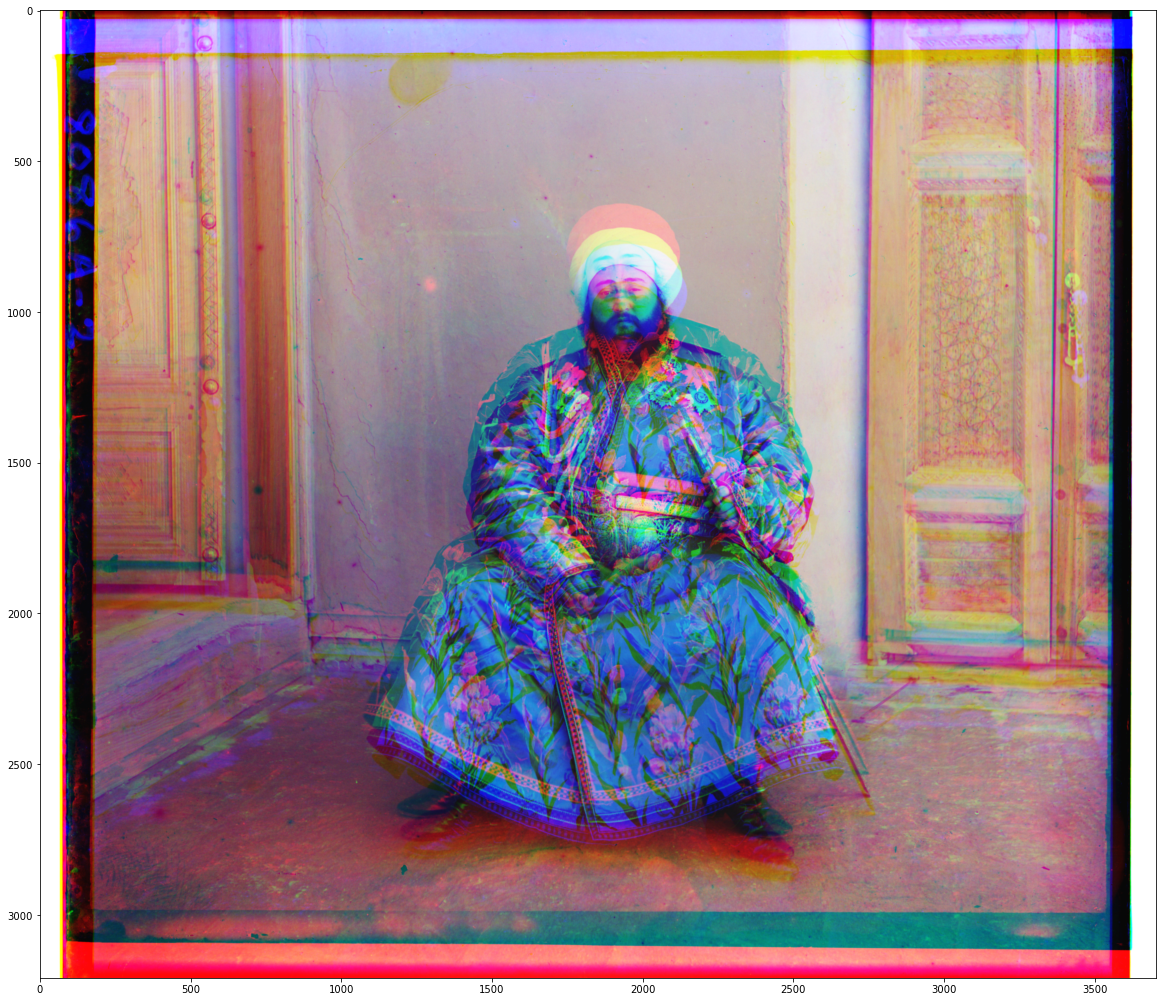

In [12]:
raw_im = cv2.imread('data/emir.tif', cv2.IMREAD_GRAYSCALE).astype(np.float32)
print(raw_im.shape)

tic = time.time()
im_r, im_g, im_b = split_raw_image(raw_im)
im_color, best_g_disp, best_b_disp = get_color_image(im_r, im_g, im_b, get_best_displacement_pyramid)
toc = time.time()
print('G channel, x-disp: {}, y-disp: {}'.format(best_g_disp[0], best_g_disp[1]))
print('B channel, x-disp: {}, y-disp: {}'.format(best_b_disp[0], best_b_disp[1]))
print('Elapsed time: {:.3f}s'.format(toc - tic))

plt.figure(figsize = (20,20))
plt.imshow(im_color.astype(np.uint8))

## Extra credit (10 points in total)
<font size="4">You can choose to finish any of the following tasks to ear the extra credit. **Save your results to the `output-extra` folder***.</font>

<font size="4" color="red">**extra task 1: can you come up with a better evaluation metric to tell how close two images are?**</font><br><br>
<font size="4">Directly comparing raw pixel values may not be the best idea.</font>

In [13]:
# your implementation

<font size="4" color="red">**extra task 2: can you come up with an *adaptive* method to remove the ugly borders in the aligned images?**</font>

In [14]:
def remove_ugly_borders(im1):
    height1, width1 = im1.shape
    im1_borderless = im1[int(0.1 * height1):-int(0.1 * height1), int(0.1 * width1):-int(0.1 * width1)]
    return im1_borderless



In [15]:
output_dir = 'output-extra'
os.makedirs(output_dir, exist_ok=True)
im_paths = sorted(glob.glob('data/*.jpg'))
for im_path_i in im_paths:
    im_name_i = os.path.basename(im_path_i)
    raw_im_i = cv2.imread(im_path_i, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    tic = time.time()
    im_r, im_g, im_b = split_raw_image(raw_im_i)
    im_r, im_g, im_b = remove_ugly_borders(im_r), remove_ugly_borders(im_g), remove_ugly_borders(im_b)
    im_color, best_g_disp, best_b_disp = get_color_image(im_r, im_g, im_b, get_best_displacement_pyramid)
    toc = time.time()
    cv2.imwrite(os.path.join(output_dir, im_name_i), im_color.astype(np.uint8)[:, :, ::-1])
    print(im_name_i)
    print('G channel, x-disp: {}, y-disp: {}'.format(best_g_disp[0], best_g_disp[1]))
    print('B channel, x-disp: {}, y-disp: {}'.format(best_b_disp[0], best_b_disp[1]))
    print('Elapsed time: {:.3f}s'.format(toc - tic))
    print('===\n')

00125v.jpg
G channel, x-disp: 1, y-disp: -4
B channel, x-disp: -1, y-disp: -10
Elapsed time: 0.048s
===

00149v.jpg
G channel, x-disp: 0, y-disp: -5
B channel, x-disp: -2, y-disp: -9
Elapsed time: 0.023s
===

00153v.jpg
G channel, x-disp: -2, y-disp: -7
B channel, x-disp: 11, y-disp: -16
Elapsed time: 0.020s
===

00351v.jpg
G channel, x-disp: -1, y-disp: -9
B channel, x-disp: -2, y-disp: 0
Elapsed time: 0.018s
===

00398v.jpg
G channel, x-disp: -1, y-disp: -6
B channel, x-disp: -4, y-disp: -12
Elapsed time: 0.018s
===

01112v.jpg
G channel, x-disp: -1, y-disp: -5
B channel, x-disp: -1, y-disp: -5
Elapsed time: 0.018s
===



(9627, 3702)
G channel, x-disp: -18, y-disp: -30
B channel, x-disp: -30, y-disp: -30
Elapsed time: 2.957s


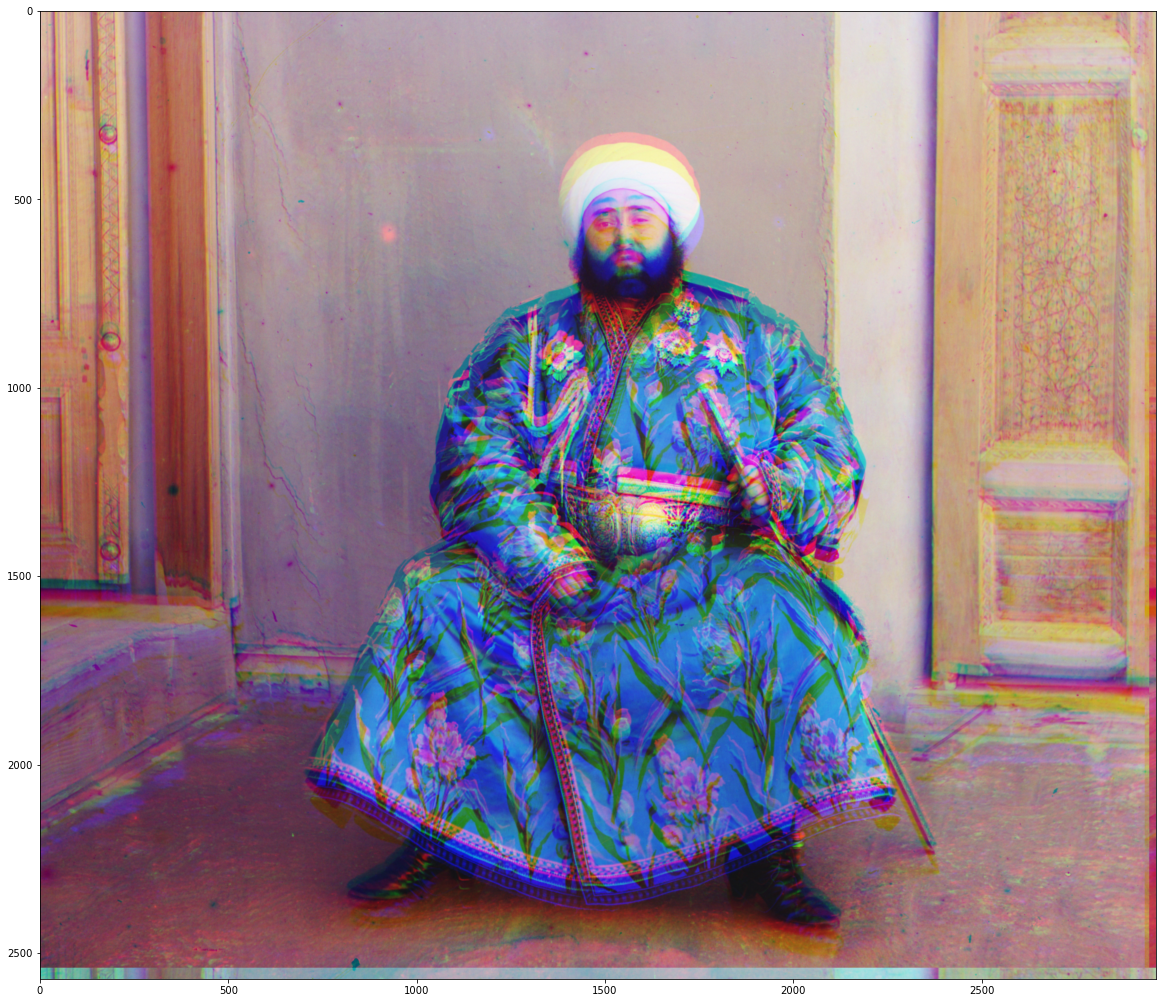

In [16]:
raw_im = cv2.imread('data/emir.tif', cv2.IMREAD_GRAYSCALE).astype(np.float32)
print(raw_im.shape)

tic = time.time()
im_r, im_g, im_b = split_raw_image(raw_im)
im_r, im_g, im_b = remove_ugly_borders(im_r), remove_ugly_borders(im_g), remove_ugly_borders(im_b)
im_color, best_g_disp, best_b_disp = get_color_image(im_r, im_g, im_b, get_best_displacement_pyramid)
toc = time.time()
print('G channel, x-disp: {}, y-disp: {}'.format(best_g_disp[0], best_g_disp[1]))
print('B channel, x-disp: {}, y-disp: {}'.format(best_b_disp[0], best_b_disp[1]))
print('Elapsed time: {:.3f}s'.format(toc - tic))

plt.figure(figsize = (20,20))
plt.imshow(im_color.astype(np.uint8))